# Wine Quality Prediction Part II

Second part of predicitng weather the overall wine quality score is good (>6.5) or bad (<6.5) using physiochemical features. The first version used a box cox transformation on features, this time I am using log traansformation and a more in depth grid search for the RandomForestClassifier parameters.

Again, the physiochemical features or columns are as follows:

1 - fixed acidity

2 - volatile acidity

3 - citric acid

4 - residual sugar

5 - chlorides

6 - free sulfur dioxide

7 - total sulfur dioxide

8 - density

9 - pH

10 - sulphates

11 - alcohol

Output variable (based on sensory data):

12 - quality (score between 0 and 10)

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# from sklearn.metrics import plot_confusion_matrix
from scipy.stats import norm, boxcox
from collections import Counter
from scipy import stats

# warning library
import warnings
warnings.filterwarnings("ignore")

In [57]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import collections

In [58]:
df = pd.read_csv(r"C:\Users\jdgoe\Downloads\winequality-red.csv")

In [59]:
#columns to transform except pH
cols = ['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
       'sulphates', 'alcohol']

## Feature Engineering - Log transformation of features

In [60]:
import feature_engine.transformation as vt
lt = vt.LogTransformer(variables = cols)

lt.fit(df)

LogTransformer(variables=['fixed acidity', 'volatile acidity', 'residual sugar',
                          'chlorides', 'free sulfur dioxide',
                          'total sulfur dioxide', 'sulphates', 'alcohol'])

In [61]:
df = lt.transform(df)

In [62]:
#Making binary classificaion for the response variable.
#Dividing wine as good and bad by giving the limit for the quality
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>, <AxesSubplot:>]],
      dtype=object)

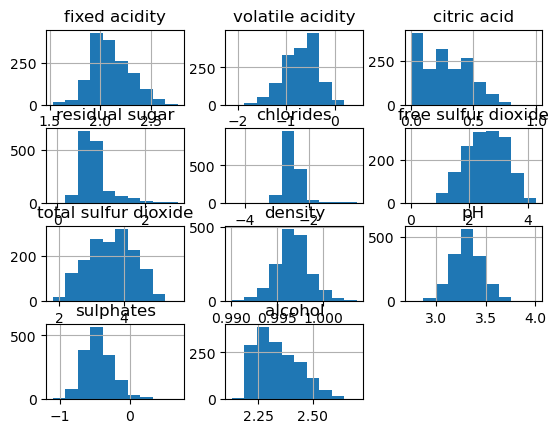

In [63]:
df.hist()

In [64]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis=1),
                                                    df['quality'],
                                                    test_size=0.25,
                                                    random_state=0)

X_train.shape, X_test.shape

((1199, 11), (400, 11))

In [65]:
# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
dct = DecisionTreeClassifier(random_state = 42)
svc = SVC(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
knn = KNeighborsClassifier()

In [67]:
# Define the list classifiers
classifiers = [
    ("knn" , knn),
    ("rf" , rf),
    ("dct", dct),
    ("svc", svc)
   ]

In [68]:
# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:
    # Fit clf to the training set
    clf.fit(X_train, y_train)
    
    # Predict y_pred
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Evaluate clf's accuracy on the test set
    print('{:s} score : {:.3f}'.format(clf_name, acc))

knn score : 0.897
rf score : 0.922
dct score : 0.902
svc score : 0.912


In [69]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 500)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 22)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
criterion = ['gini', 'entropy', 'log_loss']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion,
               
            }
print(random_grid)

{'n_estimators': [10, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257, 261, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 313, 317, 321, 325, 329, 333, 337, 341, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 675, 679, 683, 687, 691, 695, 699, 703, 707, 711, 715, 719, 723, 727, 731, 735, 739, 743, 747, 751, 755, 759, 763, 767, 771, 775, 779, 783, 787, 791, 795, 799, 803, 807, 

In [70]:
forest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = forest, param_distributions=random_grid, n_iter=200, cv=5, verbose=2, random_state=44, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60, 65,
                                                      70, 75, 80, 85, 90, 95,
                                                      100, 105, 110, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 13, 17, 21, 25, 29,
                                                         33, 37, 41, 45, 49, 53,
                                                         57, 61, 65, 69, 73, 77,
                                                         81, 85, 89, 93, 97,
                                                         101, 105, 109, 113,
                                                         117, 121, 125, ...]},
                   random_state=44, verbose=2)

In [71]:
rf_random.best_params_

{'n_estimators': 979,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 85,
 'criterion': 'gini',
 'bootstrap': True}

In [72]:
rf = RandomForestClassifier(n_estimators= 979,
 min_samples_split= 2,
 min_samples_leaf= 1,max_features='log2', bootstrap = True, max_depth=85)
rf.fit(X_train, y_train)

score = rf.score(X_test, y_test)

print("Score : ", score)

Score :  0.9225


92% Accuracy! Better than the 90% score on the last one. Unlikely we are waisting money on bad wine this weekend.